# Sistemas de Recomendación para tareas llevadas a cabo por un modelo de IA
En este notebook se hace uso de un dataset que analiza la simulación de un modelo de IA llevando a cabo diferentes tareas de diversas areas y ocupaciones.

## Cargar el dataset

In [106]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("cogsci13/Amazon-Reviews-2023-Books-Review", split="full[:1%]")  
df = dataset.to_pandas()

print("Filas cargadas:", len(df))
df.head()

Filas cargadas: 294755


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1.0,Not a watercolor book! Seems like copies imo.,It is definitely not a watercolor book. The p...,"[{'attachment_type': 'IMAGE', 'large_image_url...",B09BGPFTDB,B09BGPFTDB,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1642399598485,0,True
1,5.0,Updated: after 1st arrived damaged this one is...,Updated: after first book arrived very damaged...,[],0593235657,0593235657,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1640629604904,1,True
2,5.0,Excellent! I love it!,I bought it for the bag on the front so it pai...,[],1782490671,1782490671,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1640383495102,0,True
3,5.0,Updated after 1st arrived damaged. Excellent,Updated: after 1st arrived damaged the replace...,[],0593138228,0593138228,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1640364906602,0,False
4,5.0,Beautiful patterns!,I love this book! The patterns are lovely. I ...,"[{'attachment_type': 'IMAGE', 'large_image_url...",0823098079,0823098079,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1637312253230,0,True


## Se seleccionan solo las columnas necesarias

In [118]:
df_small = df[['user_id', 'asin']].dropna()

transactions = df_small.groupby('user_id')['asin'].apply(list)
transactions[:5]

user_id
AE223GHNZEI5MRMBVVRGJONDNWRQ     [1250847958, 0671023934, 1631065653, 1501191969]
AE224GVO7OHTYF26U6ER6BEVIUAQ    [0545381770, 0865472807, B001TLDIJY, 048624138...
AE22BZ4I2434QRWLOQ52XURGWREA    [0761156860, 1857598792, 037587514X, 080373893...
AE22CFXT3QZKUQJORVTGL3VQXAAA    [1973749122, 1099879965, 1604382066, 030792957...
AE22CS5OIRQTN7WDKQ2F3BYP5CXA                             [B01GZ60V8I, B07FTBNVGK]
Name: asin, dtype: object

## Se aplica One-Hot encoding para preparar los datos

In [112]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
onehot = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(onehot, columns=te.columns_)

df_onehot.head()

,0000013714,0001381245,000171211X,000171287X,0001714538,0001714546,0001840851,0001847775,0001850164,0001961853,...,B0BW31G83R,B0BW36MK5W,B0BW3BJZRM,B0BW7R56NT,B0BW9QR6GD,B0BWLKLQ9F,B0BWMCL813,B0BWNXFX7G,B0BXHHYMV9,B0BY3K1KLR
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Se aplica un algoritmo a priori para encontrar items frecuentes

In [144]:
from mlxtend.frequent_patterns import apriori

frequent_items = apriori(df_onehot, min_support=0.002, use_colnames=True)
frequent_items.sort_values('support', ascending=False).head()

,support,itemsets
18,0.066081,(1442450703)
23,0.008561,(B00C2WDD5I)
9,0.008141,(068983568X)
21,0.007274,(B0066U1SJU)
2,0.007050,(0399226907)


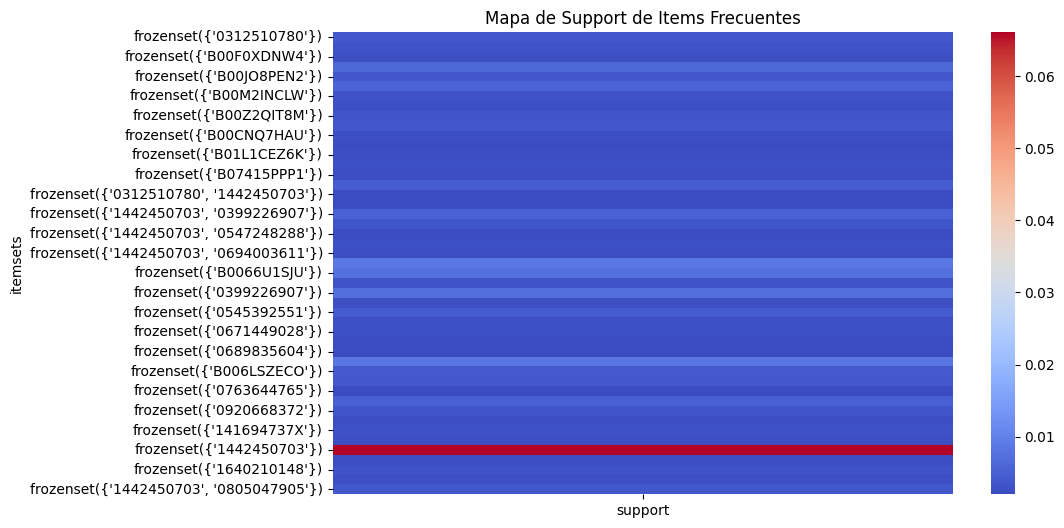

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = frequent_items.pivot_table(index='itemsets', values='support')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="coolwarm")
plt.title("Mapa de Support de Items Frecuentes")
plt.show()

## Se crean las reglas de asociación

In [121]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_items, metric="lift", min_threshold=1.0)
rules = rules.sort_values('confidence', ascending=False)

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
9,(0547248288),(1442450703),0.002658,0.066081,0.002182,0.821053,12.424939,1.0,0.002007,5.218959,0.921967,0.032787,0.808391,0.427038
7,(0545392551),(1442450703),0.004504,0.066081,0.003441,0.763975,11.561189,1.0,0.003143,3.956867,0.917637,0.051250,0.747275,0.408025
13,(0805047905),(1442450703),0.005008,0.066081,0.003749,0.748603,11.328568,1.0,0.003418,3.714922,0.916316,0.055671,0.730815,0.402667
5,(0399226907),(1442450703),0.007050,0.066081,0.005260,0.746032,11.289652,1.0,0.004794,3.677306,0.917895,0.077494,0.728062,0.412813
2,(0374360979),(1442450703),0.003077,0.066081,0.002126,0.690909,10.455485,1.0,0.001923,3.021503,0.907148,0.031720,0.669039,0.361543


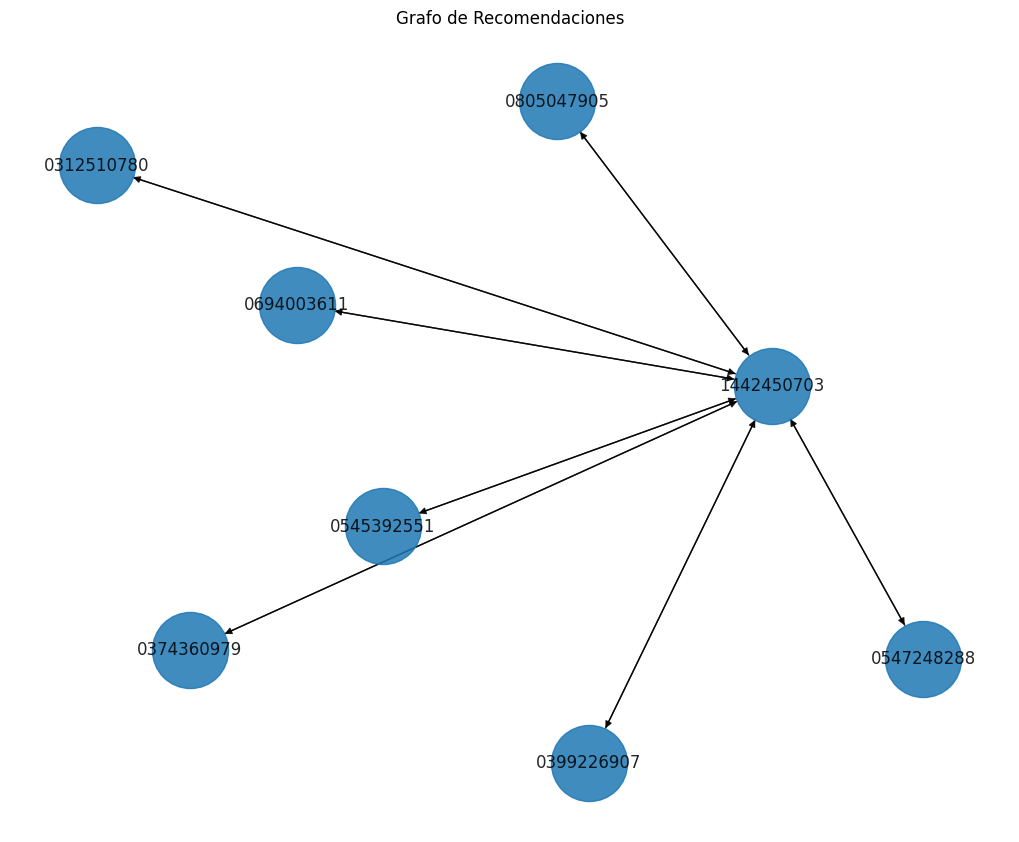

In [142]:
import networkx as nx

G = nx.DiGraph()

for _, row in rules.head(25).iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['confidence'])

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.4)
nx.draw(G, pos, with_labels=True, node_size=3000, alpha=0.85)
plt.title("Grafo de Recomendaciones")
plt.show()

## Definir una función para recomendar por usuario según las reglas

In [126]:
def recomendar_por_usuario(user_id, n=5):
    productos_usuario = set(df[df['user_id'] == user_id]['asin'])

    if len(productos_usuario) == 0:
        return f" El usuario {user_id} no tiene historial suficiente."

    candidatos = rules[rules['antecedents'].apply(lambda x: x.issubset(productos_usuario))]

    if len(candidatos) == 0:
        return f"No hay reglas asociadas a este usuario."

    sugerencias = (
        candidatos.assign(
            recomendacion=candidatos['consequents'].apply(lambda x: next(iter(x)))
        )
        .query("recomendacion not in @productos_usuario")
        .sort_values("confidence", ascending=False)
        .head(n)
    )

    return sugerencias[['recomendacion', 'confidence', 'support', 'lift']]

In [123]:
recomendar_por_usuario("AFKZENTNBQ7A7V7UXW5JJI6UGRYQ", n=5)

,recomendacion,confidence,support,lift
4,0399226907,0.079594,0.005260,11.289652
12,0805047905,0.056732,0.003749,11.328568
6,0545392551,0.052075,0.003441,11.561189
10,0694003611,0.037257,0.002462,9.864434
8,0547248288,0.033023,0.002182,12.424939
